In [4]:
%load_ext autoreload
%autoreload
import warnings; warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
%matplotlib inline
# Python dependences
import os, time
import numpy as np   # Numpy - Python's numerical library
import matplotlib.pyplot as plt  # Matplotlib - Python's plotting library
from copy import deepcopy   # Python module for copying objects

# Input and Output Tools
# Catalogue and sources 
from openquake.hmtk.parsers.catalogue import CsvCatalogueParser   # Reads an earthquake catalogue from CSV
from openquake.hmtk.parsers.catalogue.csv_catalogue_parser import CsvCatalogueWriter  # Writes an earthquake catalogue to CSV
from openquake.hmtk.parsers.source_model.nrml04_parser import nrmlSourceModelParser  # Imports a source model from XML

# Plotting tools
from openquake.hmtk.plotting.mapping import HMTKBaseMap
from openquake.hmtk.plotting.seismicity.completeness import plot_stepp_1972
from openquake.hmtk.plotting.seismicity.catalogue_plots import plot_magnitude_time_scatter
from openquake.hmtk.plotting.seismicity.catalogue_plots import plot_depth_histogram
from openquake.hmtk.plotting.seismicity.catalogue_plots import plot_magnitude_time_density
from openquake.hmtk.plotting.seismicity.max_magnitude.cumulative_moment import plot_cumulative_moment 
from openquake.hmtk.plotting.seismicity.occurrence.recurrence_plot import plot_recurrence_model
from openquake.hmtk.plotting.seismicity.catalogue_plots import (plot_observed_recurrence, 
                                                      get_completeness_adjusted_table,
                                                      _get_catalogue_bin_limits)

# Recurrence and Mmax
from openquake.hmtk.seismicity.occurrence.kijko_smit import KijkoSmit
from openquake.hmtk.seismicity.occurrence.weichert import Weichert
from openquake.hmtk.seismicity.max_magnitude.kijko_sellevol_bayes import KijkoSellevolBayes
from openquake.hmtk.seismicity.max_magnitude.kijko_sellevol_fixed_b import KijkoSellevolFixedb
from openquake.hmtk.seismicity.max_magnitude.cumulative_moment_release import CumulativeMoment
from openquake.hmtk.plotting.seismicity.max_magnitude.cumulative_moment import plot_cumulative_moment

# Catalogue selector - we will see this in action
from openquake.hmtk.seismicity.selector import CatalogueSelector

from openquake.hazardlib.mfd import TruncatedGRMFD

In [6]:
catalogue_file = "output_data/aegean_cat_dec.csv"
parser = CsvCatalogueParser(catalogue_file)
catalogue = parser.read_file(start_year=1900)

# Load in a Source Model File

In [7]:
source_model_file = "input_data/WT2006_Aegean_Sources.xml"
parser = nrmlSourceModelParser(source_model_file)

# Parse the seismic sources and save them into a variable called "source_model"
source_model = parser.read_file("Aegean Source Model 1") # You need to supply a name for the source model

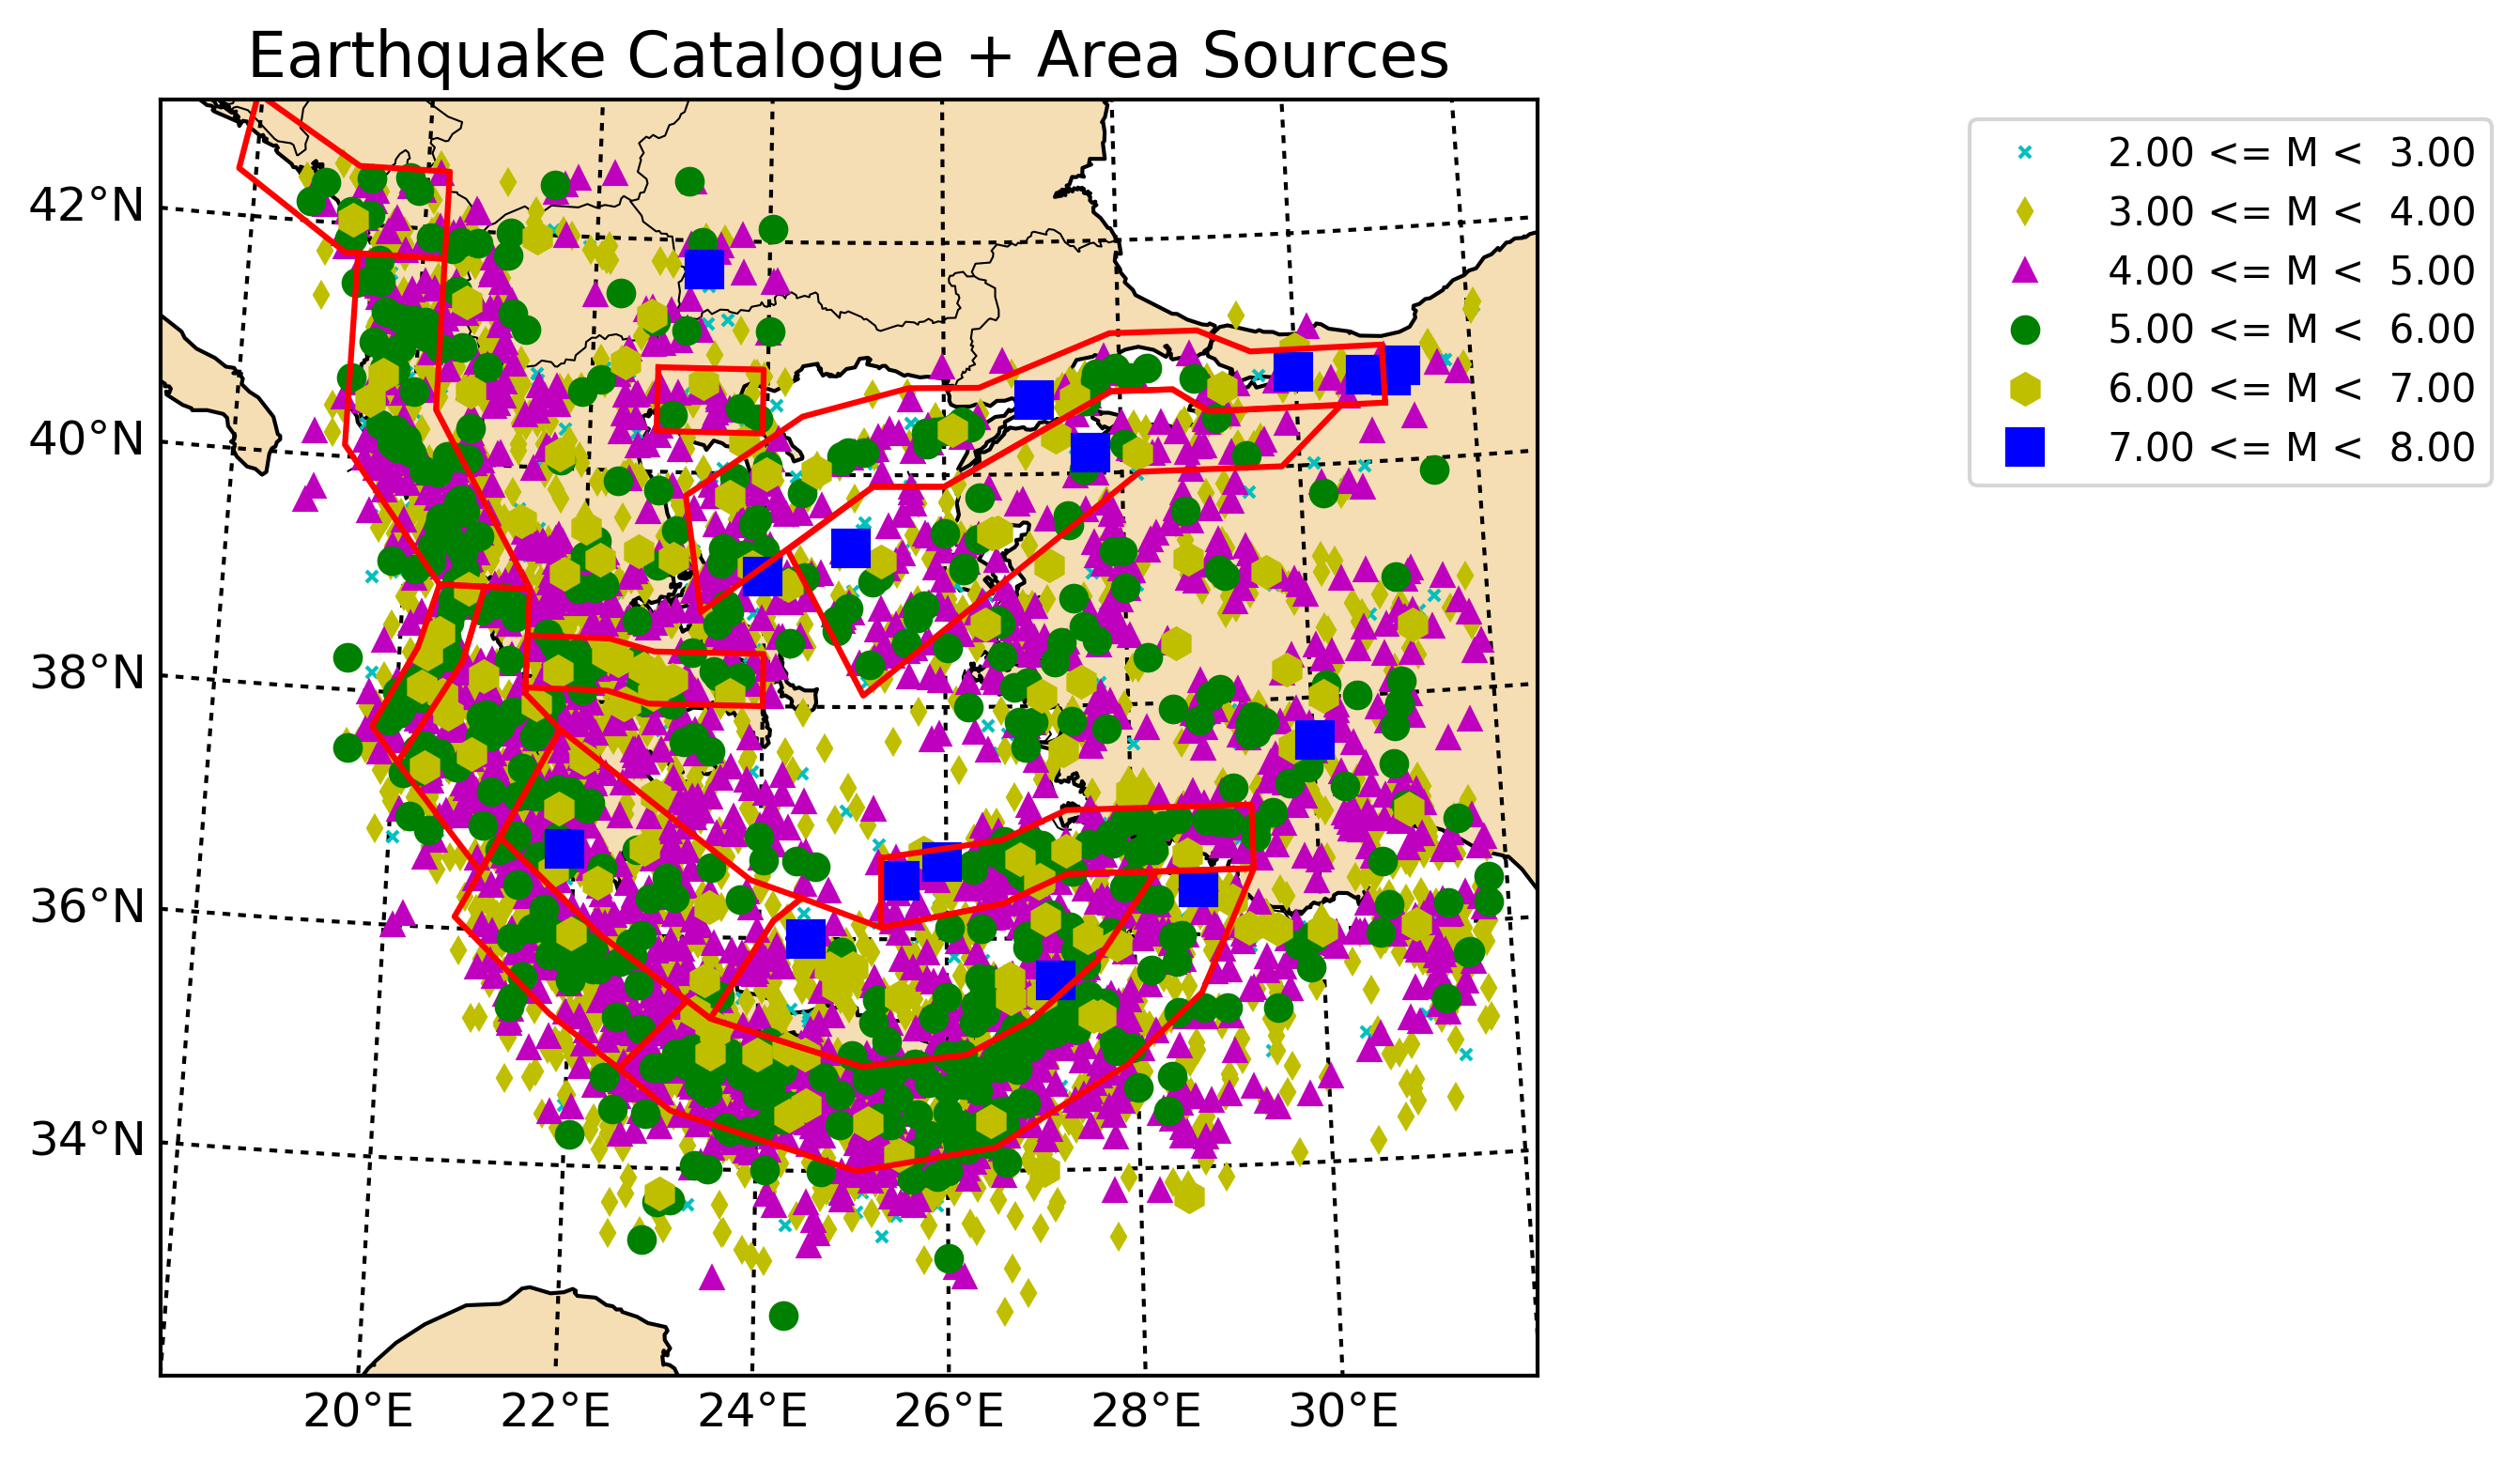

In [8]:
llon, ulon, llat, ulat = catalogue.get_bounding_box()
map_config = {'min_lon': np.floor(llon), 'max_lon': np.ceil(ulon),
              'min_lat': np.floor(llat), 'max_lat': np.ceil(ulat), 'resolution':'i'}

basemap1 = HMTKBaseMap(map_config, 'Earthquake Catalogue + Area Sources')
# Adding the catalogue to the basemap
basemap1.add_catalogue(catalogue, overlay=True)
# Adding the seismic sources
basemap1.add_source_model(source_model, area_border='r-', border_width=1.5, alpha=0.5) 

### A Source Model Workflow - Area Source Example

Each of the area sources has:

1. Defined name, ID, tectonic region type

2. Geometry (polygon)

3. Magnitude Scaling Relation (Wells & Coppersmith, 1994)

4. Rupture Aspect Ratio (1.5)

5. Nodal Plane Distribution (varies)


But they are missing the magnitude frequency distribution and the hypocentral depth distribution!

Using the observed catalogue - define the MFD as a Truncated Gutenberg-Richer model for each source

Assume $M_{MIN} = 4.5$

In [ ]:
completeness_table = np.array([[1990., 4.5],
                               [1964., 5.0],
                               [1960., 5.5],
                               [1900., 6.5]])

min_mag = 4.5

selector1 = CatalogueSelector(catalogue, create_copy=True)

In the following workflow we will, for each source:

1. Select the earthquakes within the source

2. Plot them on a map

3. Use them to calculate a- and b-value from the Weichert (1980) method

4. Estimate Mmax using the cumulative moment method (plus a small offset)

5. View the hypocentral depth distribution - and use the density to define the hypocentral depth distribution for the source

----------------------------------------------------------------------------
Source ID: 1  Source Name: Montenegro   Number of Events: 60
a = 4.193 (+/- 0.092),  b = 0.988 (+/-0.204)
Mmax (Observed) = 6.94 Mmax (Inferred) = 7.139 +/- 0.105
----------------------------------------------------------------------------
Source ID: 2  Source Name: Albania   Number of Events: 315
a = 3.973 (+/- 0.055),  b = 0.833 (+/-0.139)
Mmax (Observed) = 6.13 Mmax (Inferred) = 6.491 +/- 0.148
----------------------------------------------------------------------------
Source ID: 3  Source Name: TRGZ   Number of Events: 33
a = 2.314 (+/- 0.139),  b = 0.669 (+/-0.359)
Mmax (Observed) = 6.23 Mmax (Inferred) = 6.425 +/- 0.103
----------------------------------------------------------------------------
Source ID: 4  Source Name: Cephalonia Transform   Number of Events: 93
a = 2.289 (+/- 0.081),  b = 0.556 (+/-0.139)
Mmax (Observed) = 6.85 Mmax (Inferred) = 7.079 +/- 0.097
--------------------------------------

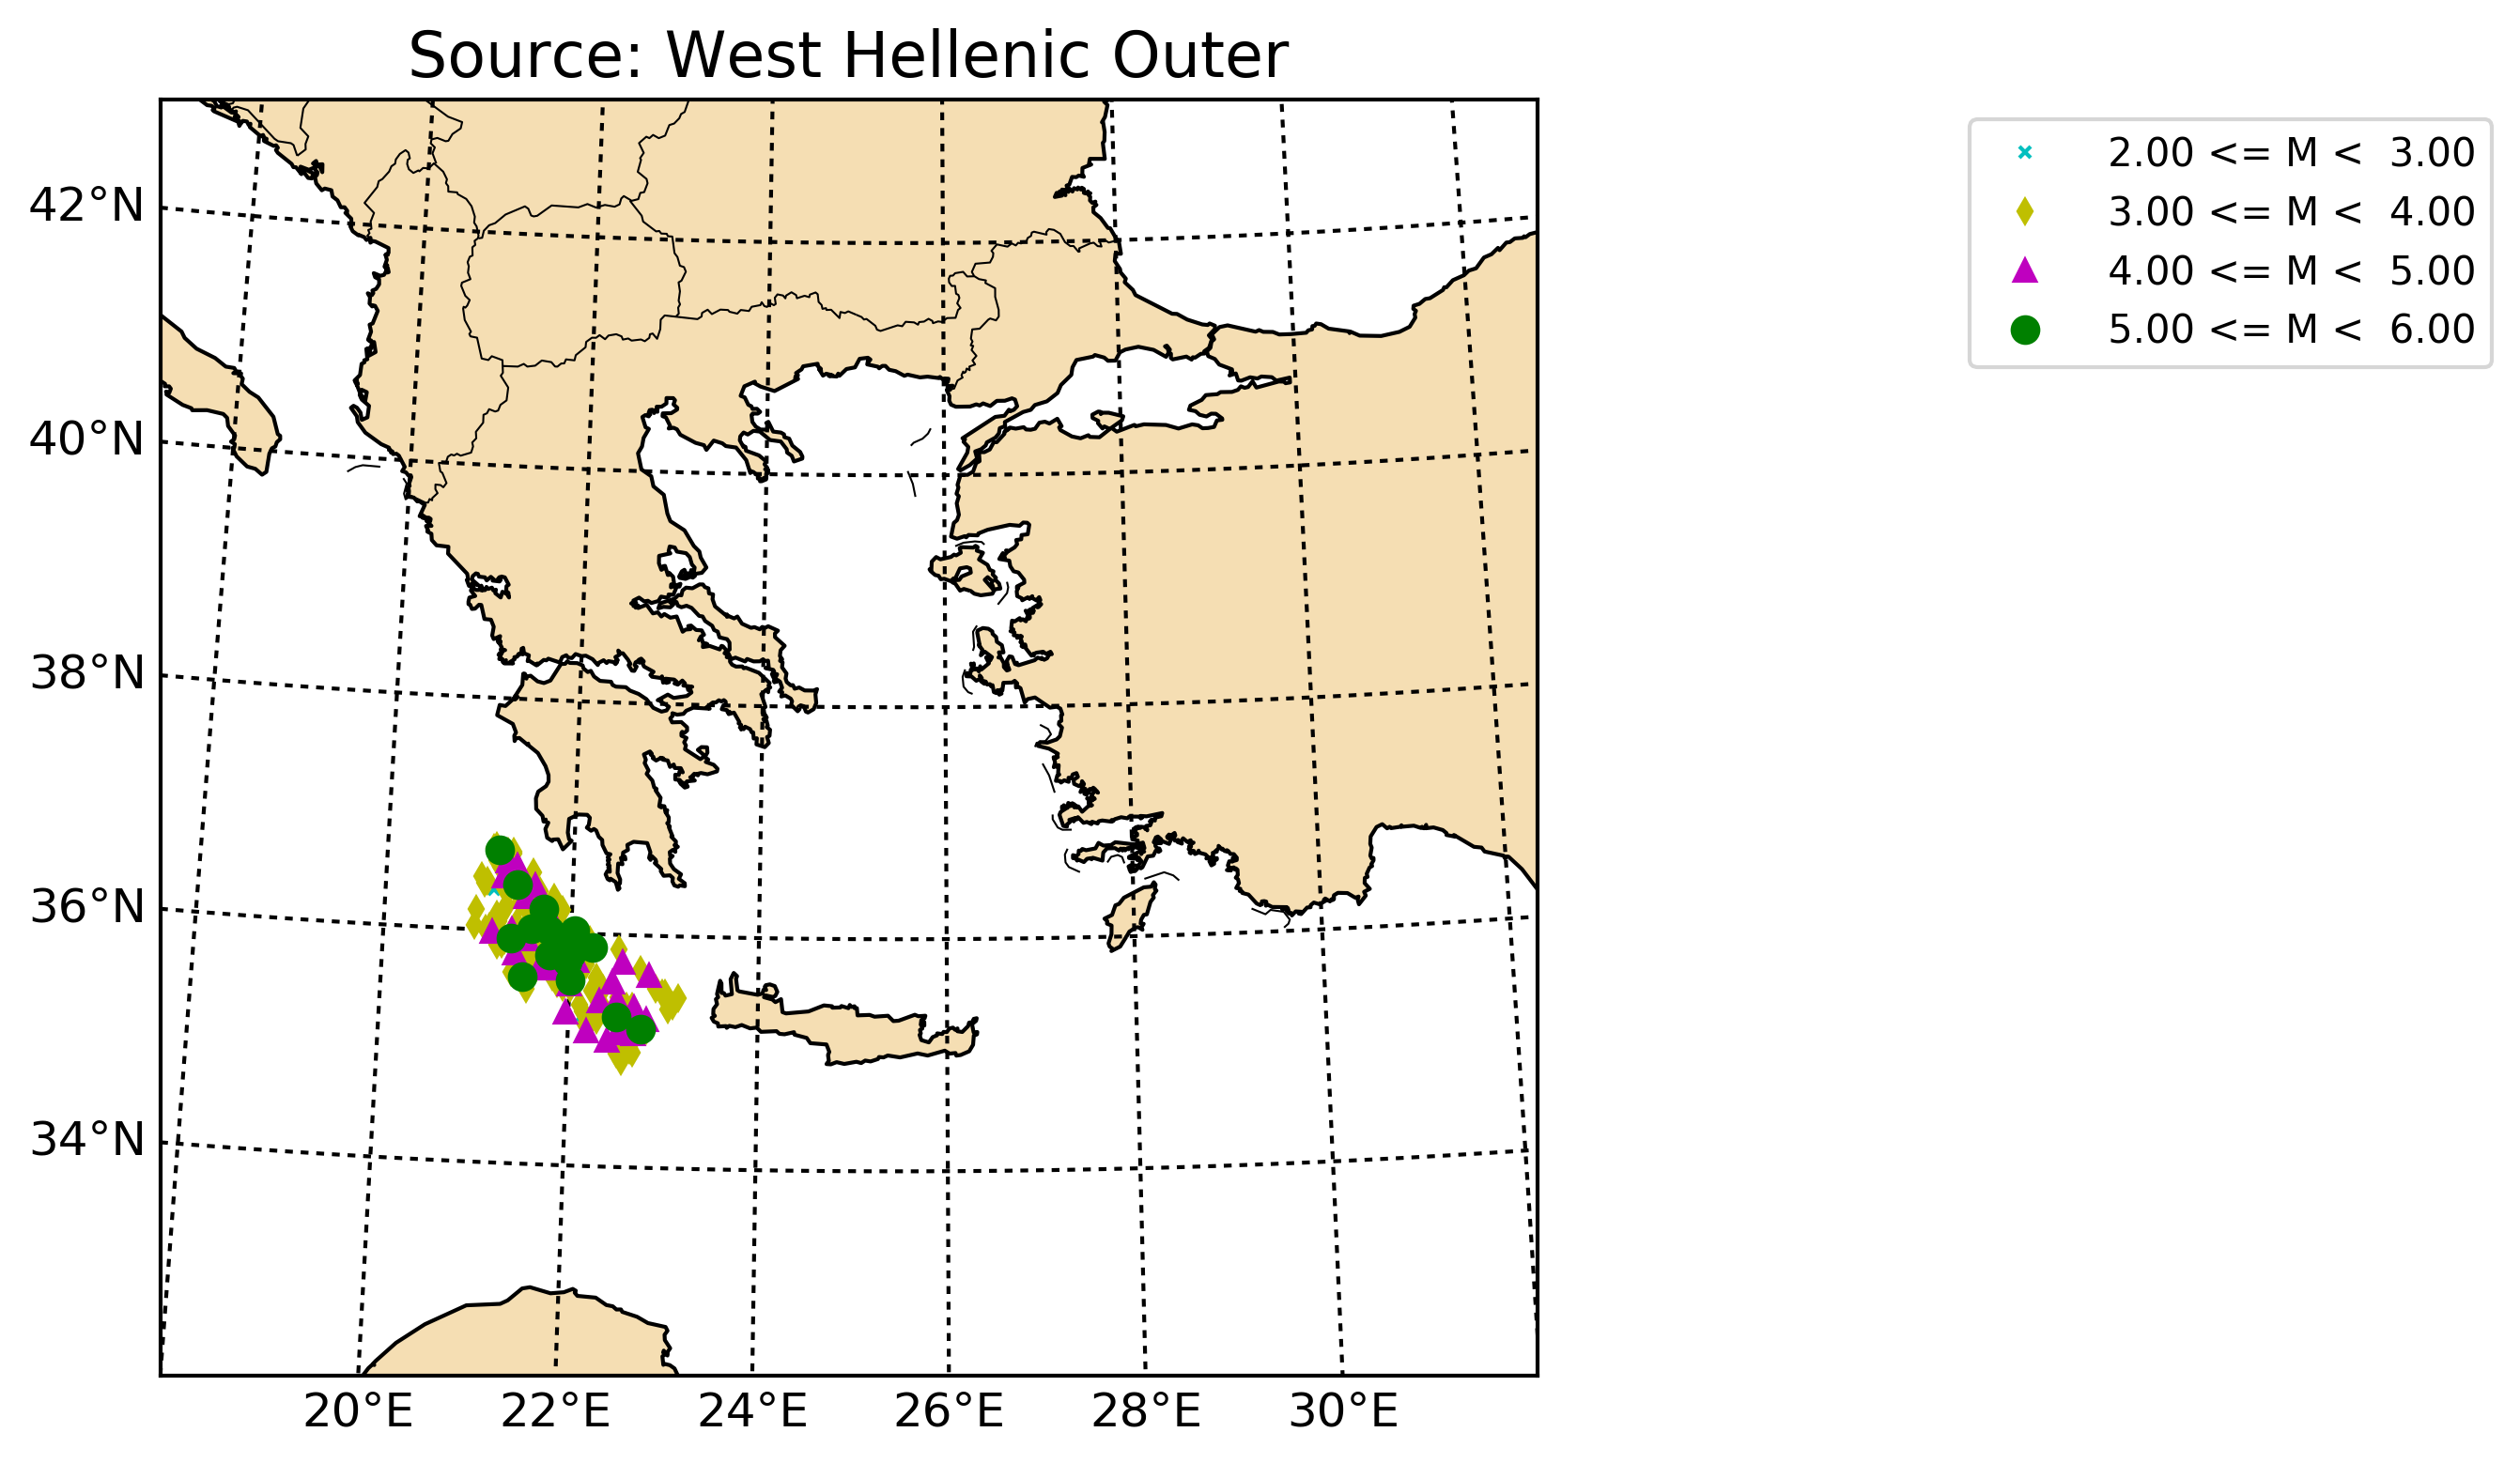

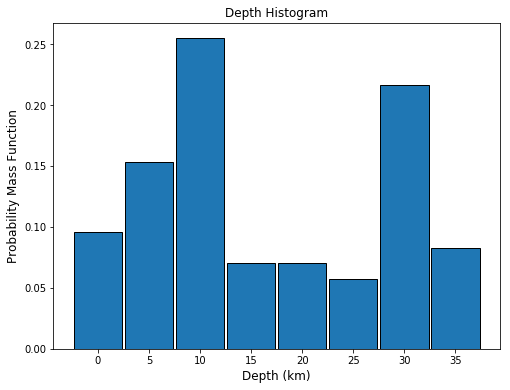

----------------------------------------------------------------------------
Source ID: 7B  Source Name: East Hellenic Outer   Number of Events: 506
a = 4.674 (+/- 0.038),  b = 0.914 (+/-0.070)
Mmax (Observed) = 7.30 Mmax (Inferred) = 7.527 +/- 0.194


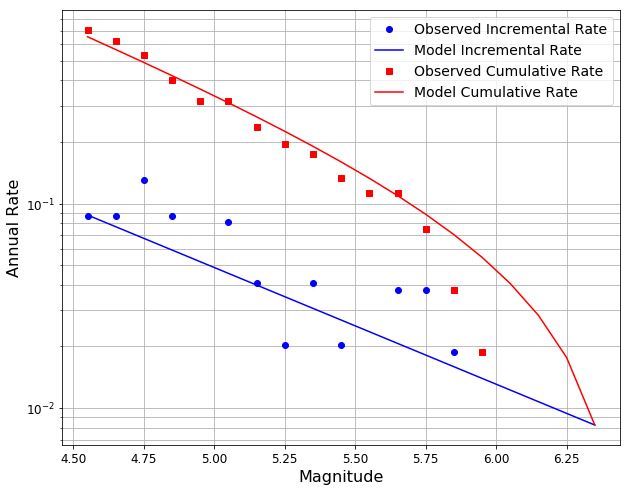

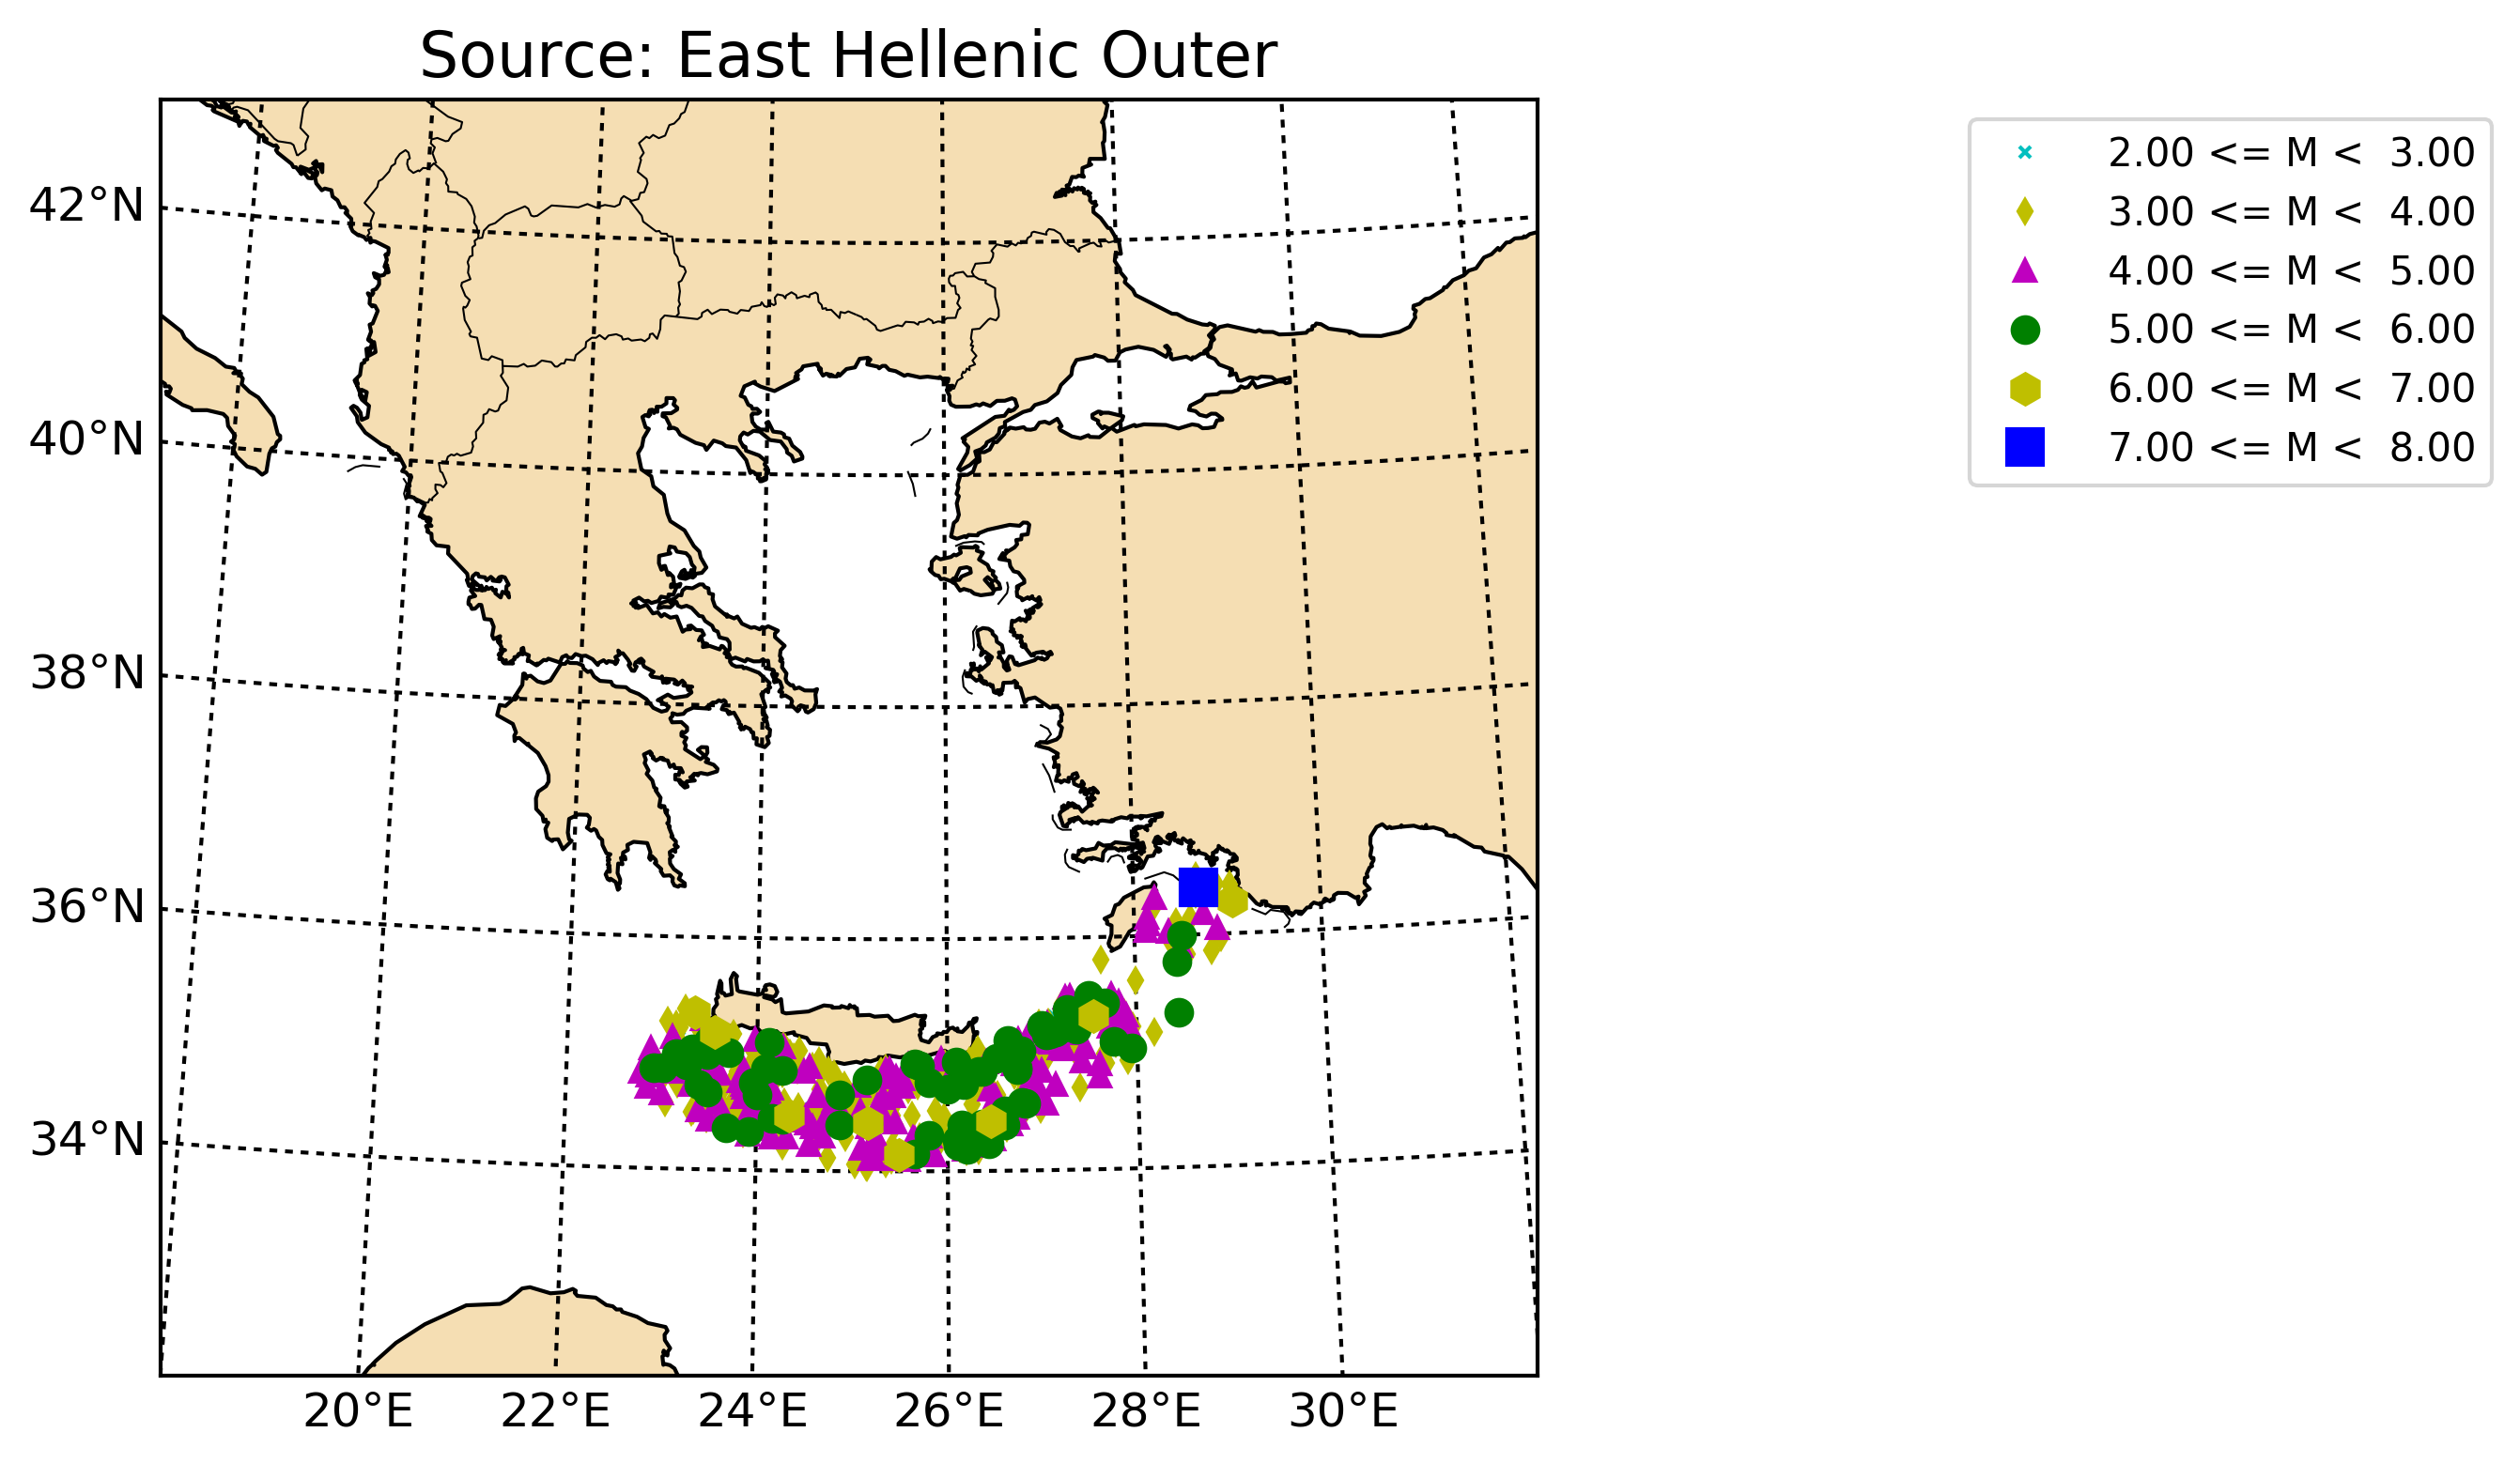

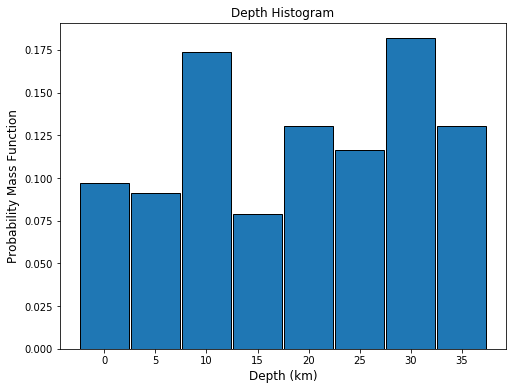

----------------------------------------------------------------------------
Source ID: 8A  Source Name: West Hellenic Inner   Number of Events: 156
a = 3.464 (+/- 0.072),  b = 0.781 (+/-0.139)
Mmax (Observed) = 6.86 Mmax (Inferred) = 7.200 +/- 0.070
----------------------------------------------------------------------------
Source ID: 8B  Source Name: East Hellenic Inner   Number of Events: 120
a = 2.915 (+/- 0.097),  b = 0.720 (+/-0.250)
Mmax (Observed) = 6.19 Mmax (Inferred) = 6.482 +/- 0.087


In [ ]:
IdList = ['7A','7B','10','11']

for source in source_model.sources:

    print '----------------------------------------------------------------------------'
    # Select the earthquakes within the source
    source.select_catalogue(selector1)
    print "Source ID: %s  Source Name: %s   Number of Events: %g" % (source.id, source.name,
                                                                     source.catalogue.get_number_events())

    # Get the a- and b-value using Weichert (1980)
    occurrence = Weichert()
    recurrence_config = {"magnitude_interval": 0.1}
    bval, sigma_b, aval, sigma_a = occurrence.calculate(source.catalogue,
                                                        recurrence_config,
                                                        completeness_table)
    print "a = %.3f (+/- %.3f),  b = %.3f (+/-%.3f)" % (aval, sigma_a, bval, sigma_b)


    # Estimate the Maximum Magnitude - using the Cumulative Moment method
    mmax_config = {"number_bootstraps": 500}
    mmax_calculator = CumulativeMoment()
    mmax, sigma_mmax = mmax_calculator.get_mmax(source.catalogue, mmax_config)
    print "Mmax (Observed) = %.2f Mmax (Inferred) = %.3f +/- %.3f" % (
        np.max(source.catalogue.data["magnitude"]), mmax + 0.2, sigma_mmax)
    
    # Compare the model against data
    source.mfd = TruncatedGRMFD(min_mag, mmax + 0.2, 0.1, aval, bval)

    if source.id in IdList:
        # Map the Source
        src_basemap = HMTKBaseMap(map_config, "Source: {:s}".format(source.name))
        # Add on the catalogue
        src_basemap.add_catalogue(source.catalogue)

        # Show the depth histogram
        depth_interval = 5.0  # in km
        plot_depth_histogram(source.catalogue, depth_interval, normalisation=True)
    
        plot_recurrence_model(source.mfd, source.catalogue, completeness_table, 0.1)
    
        # Add the probability mass function of the hypocentre depths to the source
        #depth_bins = np.arange(source.upper_depth,
        #                       source.lower_depth + depth_interval,
        #                       depth_interval)
        #source.hypo_depth_dist = source.catalogue.get_depth_pmf(depth_bins)
        # Wait for the plotting to catch up!

    time.sleep(1.0)

In [ ]:
source_model.serialise_to_nrml("output_data/New_Aegean_Source_Model.xml")

### Exploring Fault Sources in the Gulf of Corinth

In [ ]:
fault_model_file = "input_data/source_models/GulfOfCorinth_minimal.xml"
parser = nrmlSourceModelParser(fault_model_file)
fault_sources = parser.read_file("Gulf of Corinth Faults")

#### Visualise

In [ ]:
map_config = {'min_lon': 20.9, 'max_lon': 24.0,
              'min_lat': 37.5, 'max_lat': 39.0, 'resolution':'h'}

# Map the Source
src_basemap = HMTKBaseMap(map_config, "Gulf of Corinth Faults & Seismicity")
# Add on the catalogue
src_basemap.add_catalogue(catalogue, overlay=True)
src_basemap.add_source_model(fault_sources)